In [1]:
# load
import scipy.io as sio
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
import matplotlib.pyplot as plt
from fit_sigmoids import fit_sigmoid, sigmoid_func_l
import tqdm
import os.path

np.random.seed(2022)

juiceAmounts = [0.1, 0.3, 1.2, 2.5, 5, 10, 20]
dat = sio.loadmat('measured_neurons/dat_eachneuron_bc.mat')
dat = dat['dat']

num_sim = int(5e3)
initial_guess = [1, 1, 0]
remove_min = True

# load thresholds
NDAT = sio.loadmat(os.path.join("measured_neurons", "data_max.mat"))["dat"]
true_thresh = NDAT["ZC"][0, 0].squeeze()

In [34]:
ps = np.zeros((40, 3))
for i in tqdm.trange(40):
    dats = dat[0,i][0]
    datas_x = []
    datas_y = []

    for count, j in enumerate(juiceAmounts):
        y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
        x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
        datas_x.extend(x_to_extend)
        datas_y.extend(y_to_extend)

    x = np.array(datas_x)
    y = np.array(datas_y)
    if remove_min:
        y -= np.min(y)
    pars, lik = fit_sigmoid(x, y, x_init=initial_guess)
    ps[i,:] = np.array(pars)

100%|██████████| 40/40 [00:00<00:00, 258.14it/s]


In [35]:
if remove_min:
    sio.savemat('curve_fit_parameters_min.mat', {'ps':ps}) # post fix '_new' to prevent overwriting
else:
    sio.savemat('curve_fit_parameters.mat', {'ps':ps})

In [36]:
ps = np.zeros((40, num_sim, 3))
for i in tqdm.trange(40):
    dats = dat[0,i][0]
    datas_x = []
    datas_y = []

    for count, j in enumerate(juiceAmounts):
        y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
        x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
        datas_x.extend(x_to_extend)
        datas_y.extend(y_to_extend)

    x = np.array(datas_x)
    y = np.array(datas_y)
    if remove_min:
        y -= np.min(y)
    
    for simi in range(num_sim):
        i_sample = np.random.choice(np.linspace(0,len(x)-1,len(x),dtype=np.int16),len(x))
        x_ = x[i_sample]
        y_ = y[i_sample]

        # pars, pcov = curve_fit(func, x_, y_, p0=initial_guess, bounds = (0,np.inf), maxfev = int(1e4))
        pars, lik = fit_sigmoid(x_, y_, x_init=initial_guess)

        ps[i,simi,:] = np.array(pars)
        #print('neuron {} simulation {}'.format(i, simi))
        

100%|██████████| 40/40 [10:49<00:00, 16.24s/it]


In [37]:
if remove_min:
    sio.savemat('curve_fit_bootstrap_min.mat', {'ps':ps}) # post fix '_new' to prevent overwriting
else:
    sio.savemat('curve_fit_bootstrap.mat', {'ps':ps})

In [38]:
# sampling even the neurons 2020 10 25
ps = np.zeros((40, num_sim, 3))
for simi in tqdm.trange(num_sim):
    n_sample = np.random.choice(np.linspace(0,39,dtype=np.int16),40) # neuron sample
    for count_n,i in enumerate(n_sample):
        dats = dat[0,i][0]
        datas_x = []
        datas_y = []

        for count, j in enumerate(juiceAmounts):
            y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
            x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
            datas_x.extend(x_to_extend)
            datas_y.extend(y_to_extend)

        x = datas_x
        y = datas_y
        if remove_min:
            y -= np.min(y)


        i_sample = np.random.choice(np.linspace(0,len(x)-1,len(x),dtype=np.int16),len(x))
        x_ = np.array(x)[i_sample]
        y_ = np.array(y)[i_sample]

        pars, lik = fit_sigmoid(x_, y_, x_init=initial_guess)

        ps[count_n,simi,:] = np.array(pars)
        #print('neuron {} simulation {}'.format(count_n, simi))



100%|██████████| 5000/5000 [17:25<00:00,  4.78it/s]   


In [39]:
if remove_min:
    sio.savemat('curve_fit_bootstrap_neurons_min.mat', {'ps':ps}) # post fix '_new' to prevent overwriting
else:
    sio.savemat('curve_fit_bootstrap_neurons.mat', {'ps':ps})

Text(0.5, 1.0, 'min removed data')

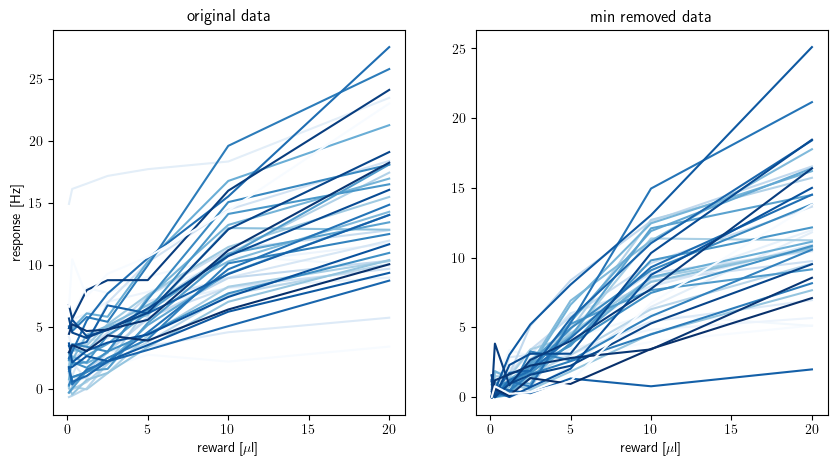

In [40]:
y = np.array([np.nanmean(dat[0,i][0], 0) for i in range(dat.shape[1])]).T
plt.rc('text', usetex=True)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,39)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ps = sio.loadmat('curve_fit_parameters.mat')['ps']
idx_sort = np.argsort(ps[:,2])
y_sorted = y[:,idx_sort]
plt.plot(juiceAmounts, y_sorted)
plt.ylabel("response [Hz]")
plt.xlabel("reward [$\mu$l]")
plt.title("original data")
plt.subplot(1,2,2)
ps = sio.loadmat('curve_fit_parameters_min.mat')['ps']
idx_sort = np.argsort(ps[:,2])
y_sorted = y[:,idx_sort]
plt.plot(juiceAmounts, y_sorted-np.min(y_sorted, 0, keepdims=True))
plt.xlabel("reward [$\mu$l]")
plt.title("min removed data")

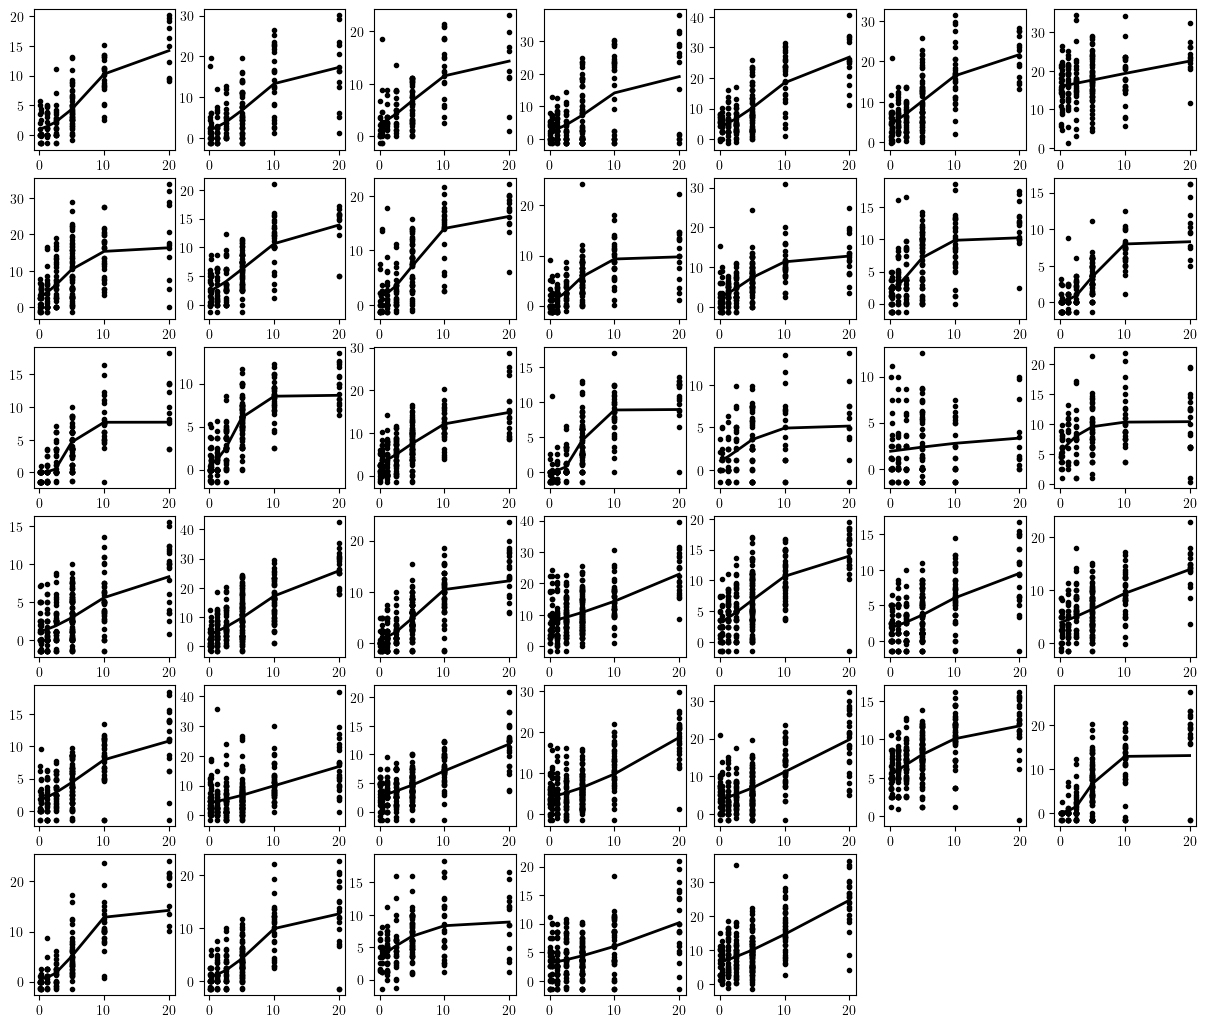

In [41]:
plt.figure(figsize=(15,15))
for i in range(ps.shape[0]):
    dats = dat[0,i][0]
    datas_x = []
    datas_y = []

    for count, j in enumerate(juiceAmounts):
        y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
        x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
        datas_x.extend(x_to_extend)
        datas_y.extend(y_to_extend)

    x = np.array(datas_x)
    y = np.array(datas_y)
    #y -= np.min(y)
    pars, lik = fit_sigmoid(x, y, x_init=initial_guess)

    plt.subplot(7,7,i+1)
    plt.plot(x, y, 'k.')
    plt.plot(x, np.exp(sigmoid_func_l(x, *pars)), 'k-', linewidth=2)

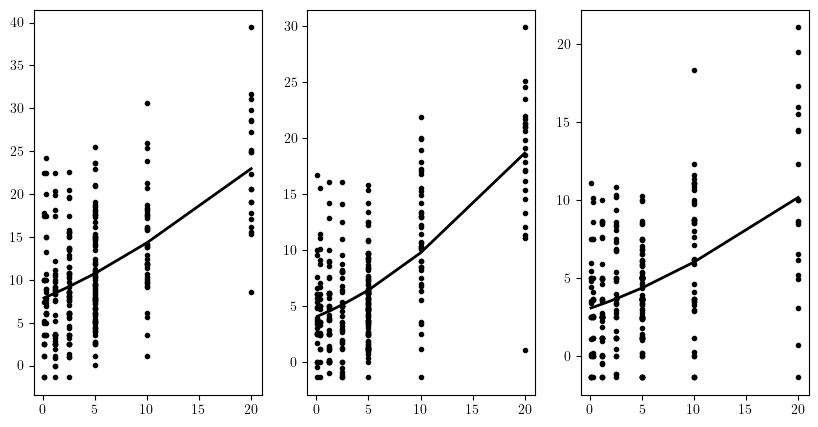

In [42]:
plt.figure(figsize=(10,5))
for i, idx in enumerate([23, 30, 37]):
    dats = dat[0,idx+1][0]
    datas_x = []
    datas_y = []

    for count, j in enumerate(juiceAmounts):
        y_to_extend = np.squeeze(dats[np.where(~np.isnan(dats[:,count])),count])
        x_to_extend = (np.ones(y_to_extend.shape)*j).tolist()    
        datas_x.extend(x_to_extend)
        datas_y.extend(y_to_extend)

    x = np.array(datas_x)
    y = np.array(datas_y)
    if remove_min:
        y -= np.min(y)
    pars, lik = fit_sigmoid(x, y, x_init=initial_guess)

    plt.subplot(1,3,i+1)
    plt.plot(x, y, 'k.')
    plt.plot(x, np.exp(sigmoid_func_l(x, *pars)), 'k-', linewidth=2)

In [43]:
dat_old = sio.loadmat('measured_neurons/curve_fit_bootstrap.mat')
dat_pars = sio.loadmat('curve_fit_bootstrap.mat')

Text(0.5, 0, 'Least-square(old)')

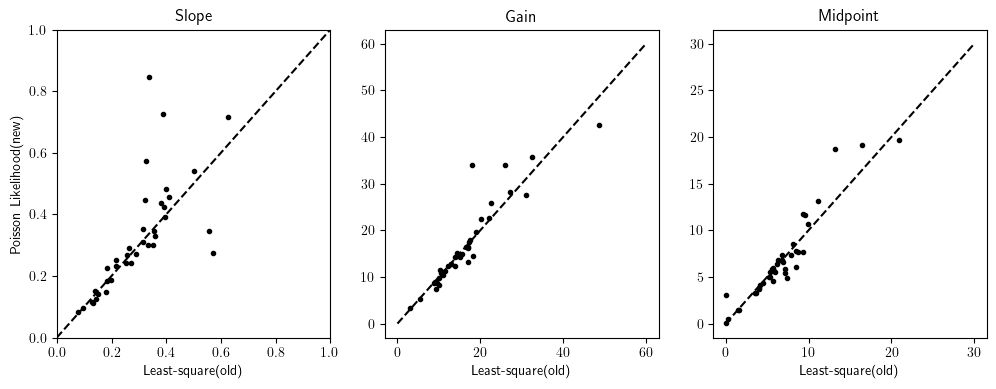

In [44]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Slope')
plt.plot(np.median(dat_old['ps'],1)[:,0], np.median(dat_pars['ps'],1)[:,0], 'k.')
plt.ylim([0,1])
plt.xlim([0,1])
plt.plot([0,1],[0,1],'k--')
plt.ylabel('Poisson Likelihood(new)')
plt.xlabel('Least-square(old)')
plt.subplot(1,3,2)
plt.title('Gain')
plt.plot(np.median(dat_old['ps'],1)[:,1], np.median(dat_pars['ps'],1)[:,1], 'k.')
plt.xlabel('Least-square(old)')
plt.plot([0,60],[0,60],'k--')
plt.subplot(1,3,3)
plt.title('Midpoint')
plt.plot(np.median(dat_old['ps'],1)[:,2], np.median(dat_pars['ps'],1)[:,2], 'k.')
plt.plot([0,30],[0,30],'k--')
plt.xlabel('Least-square(old)')